# Evaluation

In [1]:
CONFIG_PATH = './configs/cpc-v1.json'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix

from evaluate import load

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
model, history, model_spkid, history_spkid, test_gen = load(CONFIG_PATH)

Number of training batches: 2
Number of val batches: 2
Number of test batches: 2
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20480, 1)]        0         
_________________________________________________________________
cpc_encoder (CPCEncoder)     (None, 128, 512)          5260800   
_________________________________________________________________
autoregressive (Autoregressi (None, 256)               591360    
Total params: 5,852,160
Trainable params: 5,847,040
Non-trainable params: 5,120
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20480, 1)]        0         
_________________________________________________________________
cpc_model (CPCM

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/cpc-v1/history.npy'

In [11]:
def load_gen_in_memory(gen):
    X_test = []
    y_test = []
    for i in range(len(gen)):
        tmp = gen[i]
        X_test.extend(tmp[0])
        y_test.extend(tmp[1]) 
    return np.array(X_test), np.array(y_test)

# Load test_gen in memory
X_test, y_test = load_gen_in_memory(test_gen)
y_test_pred = np.argmax(model_spkid.predict(X_test), axis=-1)

print(X_test.shape)
print(y_test.shape)
print(y_test_pred.shape)

## Encoder (self-supervised trained)

### Scores

In [5]:
model.evaluate(test_gen)

2/2 [==============================] - 5s 967ms/step - loss: 3.8455 - accuracy: 0.0114


[0.012499999999999999, 3.688880205154419]

### Learning curves

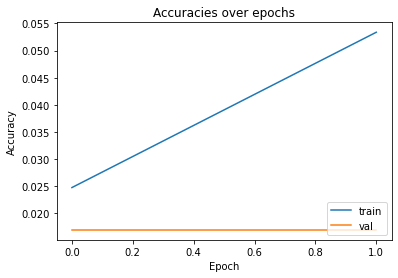

In [9]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

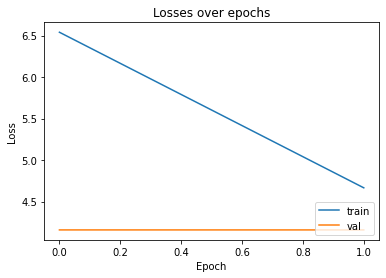

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### PCA on embeddings

In [30]:
from tensorflow.keras.layers import GlobalAveragePooling1D

def get_speakers_embeddings(ids, nb_per_speaker):
    utterances = []
    idx_speaker = 0
    for i in range(len(s_ids)):
        for j in range(len(X_test)):
            if y_test[j] == s_ids[i] and idx_speaker < nb_per_speaker:
                utterances.append(X_test[j])
                idx_speaker += 1
        idx_speaker = 0
    return np.array(utterances)

def plot_speakers_embeddings(speakers, nb_per_speaker=6):
    utterances = get_speakers_embeddings(speakers, nb_per_speaker)
    
    # Extract and project features in 2D
    features = model(utterances)
    features = GlobalAveragePooling1D()(features).numpy()

    features_embedded = PCA(n_components=2).fit_transform(features)
    features_embedded = features_embedded.reshape((len(speakers),
                                                   nb_per_speaker,
                                                   2))

    # Plot
    plt.figure(figsize=(6, 6))
    for i in range(len(speakers)):
        plt.plot(features_embedded[i, :, 0],
                 features_embedded[i, :, 1],
                 'o',
                 label="Speaker {}".format(speakers[i]))
    plt.legend(numpoints=1)

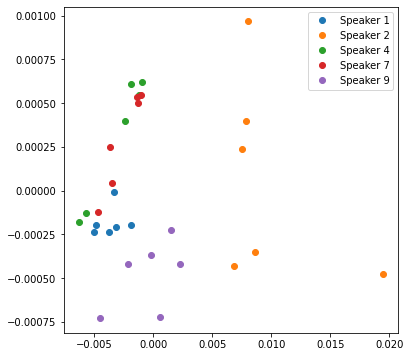

In [31]:
speakers = [1, 2, 4, 7, 9]
plot_speakers_embeddings(speakers, nb_per_speaker=6)

## Speaker ID

### Scores

In [13]:
model_spkid.evaluate(X_test, y_test)

4/4 [==============================] - 3s 572ms/step - loss: 2.2985 - accuracy: 0.1923


[2.2984604835510254, 0.19230769574642181]

In [15]:
report = classification_report(y_test, y_test_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

         0.0       0.22      0.18      0.20        11
         1.0       0.00      0.00      0.00         9
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         8
         4.0       0.18      1.00      0.30        15
         5.0       0.33      0.25      0.29         8
         6.0       0.00      0.00      0.00         6
         7.0       0.25      0.06      0.10        17
         8.0       0.00      0.00      0.00        16
         9.0       0.00      0.00      0.00         7

    accuracy                           0.19       104
   macro avg       0.10      0.15      0.09       104
weighted avg       0.12      0.19      0.10       104



### Learning curves

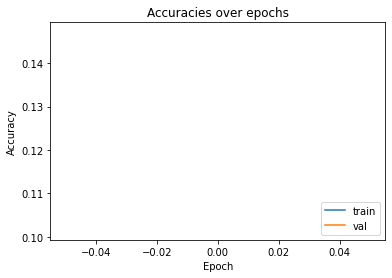

In [16]:
plt.plot(history_spkid['accuracy'])
plt.plot(history_spkid['val_accuracy'])
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

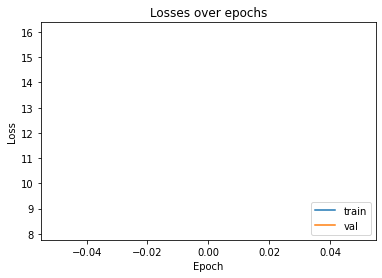

In [17]:
plt.plot(history_spkid['loss'])
plt.plot(history_spkid['val_loss'])
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### Confusion matrix

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

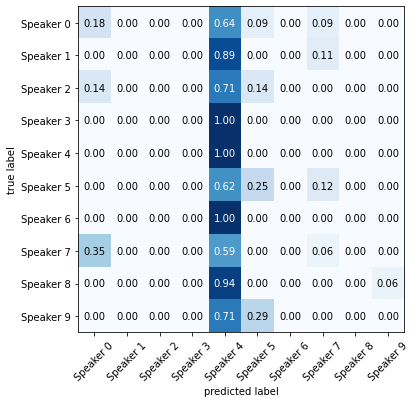

In [18]:
cm = confusion_matrix(y_test, y_test_pred)

nb_classes = len(np.unique(y_test))
class_names = ['Speaker {}'.format(i) for i in range(0, nb_classes)]

plot_confusion_matrix(cm,
                      colorbar=False,
                      show_normed=True,
                      show_absolute=False,
                      class_names=class_names,
                      figsize=(6, 6))

### Error analysis

In [79]:
import glob
from IPython.display import display, Audio

def get_speaker_info(id, dataset_path):
    speakers = glob.glob(dataset_path + '/*')
    speaker = speakers[id]
    utterances = glob.glob(speaker + '/*/*.flac')
    utterance = utterances[0]
    return speaker.split('\\')[-1], utterance

def show_errors(count=3, dataset_path=''):
    idx_error = 0
    for i in range(len(X_test)):
        if y_test[i] != y_test_pred[i] and idx_error < count:
            idx_error += 1

            print('Error {}'.format(i))

            id, path = get_speaker_info(int(y_test_pred[i]), dataset_path)
            print('Predicted speaker: {}'.format(id))
            display(Audio(path))

            id, path = get_speaker_info(int(y_test[i]), dataset_path)
            print('Actual speaker: {}'.format(id))
            display(Audio(path))

            print('=' * 40)

In [80]:
show_errors(count=3,
            dataset_path='D:/Datasets/LibriSpeech/train-clean-100')

Error 0
Predicted speaker: 1081


Actual speaker: 1183


Error 2
Predicted speaker: 1081


Actual speaker: 1088


Error 4
Predicted speaker: 1081


Actual speaker: 1116
